#Analysis of Response to Neoadjuvant Treatment in Breast Cancer Using Deep Networks


---





## Download data

In [ ]:
import zipfile

# Download data from google drive
!gdown --id 1JGqP5oL6xqb5-vfhLFcYwzEDufExehQV
local_zip = './DukeDataFinal.zip'

# Trained model 1
#!gdown --id 1MI4RpeXbRvnE2Qrp-qmSsPIVZOtTNRnx
#model_file_name = './DukeResponse-model_1.h5'

# Trained model 2
#!gdown --id 16UdQ0sLKfowUkhy1PPn72q4fE-tZo9EF
#model_file_name = './DukeResponse-model_2.h5'

# Trained model 3
#!gdown --id 17g37f6_erDF7HpT5w9TMAy20W5gYjwe8
#model_file_name = './DukeResponse-model_3.h5'

zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./')
zip_ref.close()

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1JGqP5oL6xqb5-vfhLFcYwzEDufExehQV
To: /content/DukeTestPre.zip
100% 59.1M/59.1M [00:01<00:00, 37.7MB/s]


Download clinical data

In [ ]:
!gdown --id 1nktATqZeAchrD8595mNVrGErwQzoW87y

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1nktATqZeAchrD8595mNVrGErwQzoW87y
To: /content/DukeClinicalFeatures.xlsx
100% 393k/393k [00:00<00:00, 107MB/s]


## Libraries

In [ ]:
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Imports

In [ ]:
import tensorflow as tf
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
import cv2
import random
from tensorflow.keras.layers.experimental import preprocessing
from google.colab.patches import cv2_imshow
from tensorflow.keras import datasets
import time
import math
import pandas as pd
import random
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
import glob
import scikitplot as skplt
import pathlib
import json
from google.colab import files as fs

## Reproducible results

In [ ]:
# SET SEEDS
_seed = 256
os.environ['PYTHONHASHSEED'] = str(_seed)
random.seed(_seed)
np.random.seed(_seed)
tf.random.set_seed(_seed)

# DEFINE DETERMINISTIC
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

# DEFINE PARALLELISM
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

## General variables and functions

### Read clinical data

In [ ]:
_dataFrameClinical = pd.read_excel("DukeClinicalFeatures.xlsx", header=1, skiprows=[2])

Clear clinical data

In [ ]:
_dataFrameClinicalClean = _dataFrameClinical[['Patient ID','Race and Ethnicity','ER','PR','HER2','Definitive Surgery Type','Mol Subtype','Lymphadenopathy or Suspicious Nodes']]
_dataFrameClinicalClean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 922 entries, 0 to 921
Data columns (total 8 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Patient ID                           922 non-null    object 
 1   Race and Ethnicity                   922 non-null    float64
 2   ER                                   922 non-null    float64
 3   PR                                   922 non-null    float64
 4   HER2                                 922 non-null    float64
 5   Definitive Surgery Type              915 non-null    object 
 6   Mol Subtype                          922 non-null    float64
 7   Lymphadenopathy or Suspicious Nodes  922 non-null    float64
dtypes: float64(6), object(2)
memory usage: 57.8+ KB


In [ ]:
_dataset = pd.concat([_dataFrameClinicalClean['Patient ID'], _dataFrameClinicalClean[['ER','PR','HER2']]], ignore_index=True, axis=1)#, pd.DataFrame(trainCategorical2), pd.DataFrame(trainContinuous)], ignore_index=True, axis=1)

In [ ]:
_dataset.head()

,0,1,2,3
0,Breast_MRI_001,0.0,0.0,1.0
1,Breast_MRI_002,0.0,0.0,0.0
2,Breast_MRI_003,1.0,1.0,0.0
3,Breast_MRI_004,1.0,1.0,0.0
4,Breast_MRI_005,1.0,0.0,1.0


### Hyper parameters and global variables

In [ ]:
# Input resize dimensions
input_dims = (64, 64)

# Input network shape
input_shape = (64, 64, 3)

# Batch size
batch_size = 64

# Epochs
epochs = 50

# Initial learning rate
lr = 0.0001

# Data augmentation repetition
repeat = 30

# Training stop patience
patience = 8

# Clinical data input network size
dense_input = len(_dataset.columns) - 1

### Read images function

In [ ]:
def read_files(fileName):
  """Read file

    Args:
        fileName: the name of the file.

    Returns:
        image matrix, filename and label
  """

  # Get file name
  label = tf.strings.split(fileName, os.sep)[-2]

  # Read file
  image = tf.io.read_file(fileName)

  # Decode as image
  image = tf.io.decode_jpeg(image, channels=input_shape[2])

  # Resize
  image = tf.image.resize(image, input_dims)

  return image, fileName, 1 if label == b'pcr' else 0

### Read tabular clinical data

In [ ]:
def get_tabular(fileNameBatch):
  """Read tabular data

    Args:
        fileNameBatch: List of file names.

    Returns:
        Numpy array of clinical data features
  """

  _res = []

  # For each file
  for i in fileNameBatch:
    # Get file name
    _fileName = str(i).split('/')

    # Get patient name
    _str = _fileName[len(_fileName) - 1].split("-")[0]

    # Find the patient on the clinical data
    _row = _dataset.loc[_dataset[0] == _str]

    # If not found print
    if len(_row) == 0:
      print(_str)

    # Get patient clinical data
    _out = _row.drop(0, axis=1).to_numpy().ravel()

    # Append to result
    _res.append(_out)

  # Transforms the result in a numpy array
  _res = np.array(_res)

  return _res

## Model

### Multiplication layer

In [ ]:
def mult_dense(x, y):
  """Multiplication of feature map with a scalar value

    Args:
        x: Scalar value
        y: Feature map matrix

    Returns:
        New feature map
  """

  return tf.reshape(x, (-1, 1, 1, x.shape[1])) * y

### Convolution block

In [ ]:
def convBlock(input, kernels, kernel_size, padding, initializer, total_convs):
  """Convolution block layer with batch normalization, ReLU and pooling

    Args:
        input: Batch of images
        kernels: Number of kernels for convolution layer
        kernel_size: Size of kernels for convlution layer
        padding: Padding size for convolution layer
        initializer: Kernel initializer function
        total_convs: Number of convolution operations

    Returns:
        Feature map
  """

  x = input

  for i in range(total_convs):
    # Convolution operation
    x = tf.keras.layers.Conv2D(kernels, kernel_size=kernel_size, padding=padding, kernel_initializer=initializer)(x)

    # Batch normalization
    x = tf.keras.layers.BatchNormalization()(x)

    # ReLU
    x = tf.keras.layers.ReLU()(x)

  # Pooling = Another convolution with stride of 2 (reduce the input size)
  x = tf.keras.layers.Conv2D(kernels, kernel_size=(2,2), padding=padding, strides = (2,2), kernel_initializer=initializer)(x)

  return x

### Dense convolution block

In [ ]:
def denseConvBlock(input, dense, size, initializer):
  """Dense layer using batch normalization and ReLU, multiplying the neurons with the feature maps

    Args:
        input: Batch of feature maps
        dense: Dense layer input
        size: Number of neurons
        initializer: Kernel initializer function

    Returns:
        Tuple of new feature map and dense output
  """

  # Dense layer
  x = tf.keras.layers.Dense(size, kernel_initializer=initializer)(dense)

  # Batch normalization
  x = tf.keras.layers.BatchNormalization()(x)

  # Relu
  x = tf.keras.layers.ReLU()(x)

  # Multiply
  return mult_dense(x,input), x

### Model definition

In [ ]:
def BaseModel(shape = input_shape, shape2 = (dense_input,), normalize=tf.keras.layers.Normalization()):
  """Model creation

    Args:
        shape: input shape of images for convolution network
        shape2: input shape of clinical data for dense network
        normalize: normalize function of images

    Returns:
        Keras model (not compiled)
  """

  # Defines the kernel initializer
  initializer = tf.keras.initializers.GlorotUniform(seed=_seed)

  # Image input
  inputs = tf.keras.layers.Input(shape)

  # Clinical data input
  inputs2 = tf.keras.layers.Input(shape2)

  # Initial number of filters
  _initialFilters = 32

  # Normalize images
  x = normalize(inputs)

  # Add padding to images
  x = tf.keras.layers.ZeroPadding2D(padding=2)(x)

  # Clinical data
  d = inputs2

  # First block -> 2 conv operations of 5 x 5 | 32 filters
  x = convBlock(x, _initialFilters, 5, 'same', initializer, 2)

  # Dense layer of 32 neurons multiplying feature maps
  x, d = denseConvBlock(x, d, _initialFilters, initializer)

  # Second block -> 2 conv operations of 5 x 5 | 64 filters
  _filters = 64
  x = convBlock(x, _filters, 5, 'same', initializer, 2)
  x, d = denseConvBlock(x, d, _filters, initializer)

  # Third block -> 3 conv operations of 3 x 3 | 128 filters
  _filters = 128
  x = convBlock(x, _filters, 3, 'same', initializer, 3)
  x, d = denseConvBlock(x, d, _filters, initializer)

  # Fourth block -> 3 conv operations of 3 x 3 | 256 filters
  _filters = 256
  x = convBlock(x, _filters, 3, 'same', initializer, 3)
  x, d = denseConvBlock(x, d, _filters, initializer)

  # Fifth block -> 4 conv operations of 3 x 3 | 256 filters
  _filters = 256
  x = convBlock(x, _filters, 3, 'same', initializer, 4)
  x, d = denseConvBlock(x, d, _filters, initializer)

  # Sixth block -> 5 conv operations of 2 x 2 | 512 filters
  _filters = 512
  x = convBlock(x, _filters, 2, 'same', initializer, 5)
  x, d = denseConvBlock(x, d, _filters, initializer)

  # Flatten feature maps
  x = tf.keras.layers.Flatten()(x)

  # Dropout of 20%
  z = tf.keras.layers.Dropout(0.2)(x)

  # Output dense layer of one neuron
  z = tf.keras.layers.Dense(1, kernel_initializer=initializer)(z)

  # Add sigmoid activation
  z = tf.keras.layers.Activation('sigmoid')(z)

  # Return keras model using both inputs
  return tf.keras.models.Model(inputs=[inputs, inputs2], outputs=z)

In [ ]:
BaseModel().summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 normalization (Normalization)  (None, 64, 64, 3)    7           ['input_1[0][0]']                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 68, 68, 3)   0           ['normalization[0][0]']          
                                                                                                  
 conv2d (Conv2D)                (None, 68, 68, 32)   2432        ['zero_padding2d[0][0]']         
                                                                                              

### Augmentation sequential model

In [ ]:
trainAug = tf.keras.Sequential([
  # Horizontal and vertical flip
  preprocessing.RandomFlip("horizontal_and_vertical", seed=_seed),
  # Zoom
  preprocessing.RandomZoom(
    height_factor=0.3,
    width_factor=0.3,
    seed=_seed,
    fill_mode='constant'
  ),
  # Rotation
  preprocessing.RandomRotation(0.3, fill_mode='constant', seed=_seed),
  # Translation
  preprocessing.RandomTranslation(
    height_factor=0.3,
    width_factor=0.3,
    seed=_seed,
    fill_mode='constant'
  )
])

## Training

Global metrics and variables

In [ ]:
global_hist_loss = []
global_hist_val_loss = []
global_hist_acc = []
global_hist_val_acc = []

global_acc = []
global_bacc = []
global_f1 = []
global_recall = []
global_precision = []
global_auc = []
global_sensitivity = []
global_specificity = []

global_tn = []
global_fp = []
global_fn = []
global_tp = []

global_specificity = []
global_sensitivity = []

global_acc_p = []
global_bacc_p = []
global_f1_p = []
global_recall_p = []
global_precision_p = []
global_auc_p = []
global_sensitivity_p = []
global_specificity_p = []

global_tn_p = []
global_fp_p = []
global_fn_p = []
global_tp_p = []

global_specificity_p = []
global_sensitivity_p = []

roc_list = []
roc_list_p = []
_stop = False

### Cross validation training

In [ ]:
for i in range(3):
  # Path to get data
  rootpath = 'data'
  basedir = f'{rootpath}/fold{i+1}'
  traindir = f'{basedir}/trainDir'
  traindir_path = pathlib.Path(traindir)
  valdir = f'{basedir}/validationDir'
  valdir_path = pathlib.Path(valdir)

  # Train and validation files
  train_files = tf.data.Dataset.list_files(str(traindir_path/'*/*'), seed=_seed)
  val_files = tf.data.Dataset.list_files(str(valdir_path/'*/*'), seed=_seed)

  # Labeled data
  labeled_ds = train_files.map(read_files)
  labeled_ds_val = val_files.map(read_files)

  train_ds_size = tf.data.experimental.cardinality(labeled_ds).numpy()
  print(f'\n *************************** START FOLD {i+1} / {train_ds_size * repeat} IMAGES  *************************** \n')

  # Nadam optimizer
  optimizer = tf.keras.optimizers.Nadam(learning_rate=lr)

  # Binary cross entropy loss function
  bce = tf.keras.losses.BinaryCrossentropy()

  # Train step
  @tf.function
  def train_step(data, labels):
    with tf.GradientTape() as tape:
        # Generate model predictions
        prediction = model(data, training=True)

        # Calculate error
        err = bce(labels, prediction)

    # Generate gradients
    gradient = tape.gradient(err, model.trainable_variables)

    # Apply gradients to the optimizer
    optimizer.apply_gradients(zip(gradient, model.trainable_variables))

    # Return mean error and predicted result
    return tf.reduce_mean(err), prediction

  # Test step
  @tf.function
  def test_step(data, labels):
    # Generate model predictions
    prediction = model(data, training=False)

    # Calculate error
    err = bce(labels, prediction)

    # Return mean error and predicted result
    return tf.reduce_mean(err), prediction

  # Create normalization layer
  _normLayer = tf.keras.layers.Normalization(axis=None)

  # Fit data to the normalization layer
  _normLayer.adapt(labeled_ds.map(lambda x,y,z: x))

  # Create the model
  model = BaseModel(normalize=_normLayer)

  # Compile the model (So we can save it)
  model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer = tf.keras.optimizers.Nadam(learning_rate=lr))

  # Metrics
  hist_loss = []
  hist_val_loss = []
  hist_acc = []
  hist_val_acc = []

  # Training stop control variables
  wait = 0
  best = 0

  start_time = time.time()

  print(f'\n *************************** START TRAINING  *************************** \n')

  # For each epoch
  for e in range(epochs):
    _error = []
    _valError = []

    print(f'{"=" * 10}')

    print(f'Start epoch {e+1}/{epochs} - FOLD {i+1}')

    print('Learning rate: {0:.6f}'.format(optimizer._decayed_lr(tf.float32).numpy()))

    # Initialize training and validation confusion matrix
    cm = np.zeros((2,2))
    cm_val = np.zeros((2,2))

    # Repeat the data, shuffle and generate batches
    for p, z, y in labeled_ds.repeat(count=repeat).shuffle(buffer_size=train_ds_size,reshuffle_each_iteration=True, seed=_seed).batch(batch_size):
      # Transform images using data augmentation
      _aug = trainAug(p, training=True)

      # Do train step using augmented images and clinical data
      #   and generate error/predictions
      err, pred = train_step((_aug, get_tabular(z)),y)

      # Append to error output
      _error.append(err.numpy())

      # Generate batch confusion matrix
      cm = cm + metrics.confusion_matrix(y, np.asarray(pred) >= 0.5)

    # Print confusion matrix
    print(f'Generating metrics for epoch {e+1}/{epochs} - FOLD {i+1}')
    print(cm)

    # Get validation data batches
    for p, z, y in labeled_ds_val.batch(batch_size):
      # Do test step using validation data and clinical data
      err, pred = test_step((p,get_tabular(z)),y)

      # Append to output error
      _valError.append(err.numpy())

      # Generate validation confusion matrix for batch
      cm_val = cm_val + metrics.confusion_matrix(y, np.asarray(pred) >= 0.5)

    # Print validation confusion matrix
    print(cm_val)

    # Training and validation metrics history
    train_loss = np.mean(_error)
    val_loss = np.mean(_valError)

    hist_loss.append(train_loss)
    hist_val_loss.append(val_loss)

    # Calculate specificity and sensitivity based on confusion matrix
    _spec = (cm[0,0]+cm[0,1])
    _sens = (cm[1,1]+cm[1,0])

    specificity = cm[0,0] / _spec if _spec > 0 else 0
    sensitivity = cm[1,1] / _sens if _sens > 0 else 0

    _spec = (cm_val[0,0]+cm_val[0,1])
    _sens = (cm_val[1,1]+cm_val[1,0])

    specificity = cm_val[0,0] / _spec if _spec > 0 else 0
    sensitivity = cm_val[1,1] / _sens if _sens > 0 else 0

    # Calculate balanced accuracy using specificity and sensitivity
    train_acc = (specificity + sensitivity) / 2
    hist_acc.append(train_acc)

    val_acc = (specificity + sensitivity) / 2
    hist_val_acc.append(val_acc)

    # Print epoch metrics
    print(f'Epoch Error: {train_loss:0.3f} / Epoch Validation Error: {val_loss:0.3f} | Epoch Acc: {train_acc:0.3f} / Epoch Validation Acc: {val_acc:0.3f}')

    # Training stop control
    # If epoch greater than 5
    if e >= 5:
      # Add to wait variable
      wait += 1

      # If current validation accuracy greater than best update save model
      if val_acc >= best:
        # Set new best accuracy
        best = val_acc

        # Reset wait variable
        wait = 0

        print('Model enhanced')

        # Save model
        model.save(f"./model_{i+1}.h5")
      else:
        print('Model did not enhanced')

      # If wait variable greater than patience stop training
      if wait >= patience:
       print(f'Stop training because model did not enhanced within {patience} epochs')
       wait = 0
       break
    else:
      # If epochs before 5 save model directly
      model.save(f"./model_{i+1}.h5")

    print('\n')

  train_time = f'Training time (seconds): {time.time()-start_time}'

  print(train_time)

  print(f'\n *************************** TRAINING METRICS FOLD {i+1}  *************************** \n')

  # Accuracy history plot
  plt.plot(hist_acc)
  plt.plot(hist_val_acc)
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  # Loss history plot
  plt.plot(hist_loss)
  plt.plot(hist_val_loss)
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  # Global history metrics
  global_hist_acc.append(hist_acc)
  global_hist_val_acc.append(hist_val_acc)
  global_hist_loss.append(hist_loss)
  global_hist_val_loss.append(hist_val_loss)

  # Load saved model
  model = tf.keras.models.load_model(f'model_{i+1}.h5')

  # Generate training outputs
  prediction = []
  _y = []

  for p, z, y in labeled_ds.batch(batch_size):
    prediction.extend(model((p, get_tabular(z))).numpy().ravel())#(p, get_tabular(z))
    _y.extend(y.numpy())

  y_true = _y
  probas = prediction
  out = np.asarray(prediction) >= 0.5

  # Calculate metrics
  print(f'\n *************************** AUC FOLD {i+1}  *************************** \n')

  # Calculate roc curve
  fpr_keras, tpr_keras, thresholds_keras = metrics.roc_curve(y_true, probas)

  # Calculate AUC
  __auc = metrics.roc_auc_score(y_true, probas)

  # Plot roc curve with AUC
  plt.figure(1)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr_keras, tpr_keras, label='AUC (area = {:.3f})'.format(__auc))
  plt.xlabel('False positive')
  plt.ylabel('True positive')
  plt.title('Curva ROC')
  plt.legend(loc='best')
  plt.show()

  # Print confusion matrix
  print(f'\n *************************** CONFUSION MATRIX FOLD {i+1}  *************************** \n')
  print(metrics.confusion_matrix(y_true, out))
  print(metrics.accuracy_score(y_true, out))
  print(metrics.balanced_accuracy_score(y_true, out))
  print(metrics.f1_score(y_true, out))
  print(metrics.precision_score(y_true, out))
  print(metrics.recall_score(y_true, out))
  print(metrics.jaccard_score(y_true, out))

  # Generate metrics for validation
  prediction = []
  _y = []
  files = []

  y_true_patients = {}
  y_pred_patients = {}
  y_probas_patients = {}

  for p, z, y in labeled_ds_val.batch(batch_size):
    prediction.extend(model((p,get_tabular(z))).numpy().ravel())#(p,get_tabular(z))
    _y.extend(y.numpy())
    files.extend(z)

  # Using predictions, generate metrics for patients
  for (y, _file, _pred, _prob) in zip(_y, files, (np.asarray(prediction) >= 0.5).astype("float"), prediction):
    _split = str(_file).split("/")
    _str = _split[len(_split) - 1].split("-")[0]

    if y_true_patients.get(_str) is None:
      y_true_patients[_str] = y

    if y_pred_patients.get(_str) is None:
      y_pred_patients[_str] = [_pred]
    else:
      y_pred_patients[_str].append(_pred)

    if y_probas_patients.get(_str) is None:
      y_probas_patients[_str] = [_prob]
    else:
      y_probas_patients[_str].append(_prob)

  for p in y_probas_patients:
    # Patient probability is the median
    y_probas_patients[p] = np.median(y_probas_patients[p])

    # Patient response is the mode
    y_pred_patients[p] = stats.mode((np.array(y_pred_patients[p]) >= 0.5).astype("float"))[0][0]

  y_true = _y
  probas = prediction
  out = np.asarray(prediction) >= 0.5

  y_true_p = np.array(list(y_true_patients.values()))
  out_p = np.array(list(y_pred_patients.values()))
  probas_p = np.array(list(y_probas_patients.values()))

  # Validation metrics
  print(f'\n *************************** AUC VALIDATION FOLD {i+1}  *************************** \n')

  # Validation roc curve
  fpr_keras, tpr_keras, thresholds_keras = metrics.roc_curve(y_true, probas)

  # Validation AUC
  __auc = metrics.roc_auc_score(y_true, probas)

  # Plot validation roc curve with AUC
  plt.figure(1)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr_keras, tpr_keras, label='AUC (area = {:.3f})'.format(__auc))
  plt.xlabel('False positive')
  plt.ylabel('True positive')
  plt.title('Curva ROC Images')
  plt.legend(loc='best')
  plt.show()

  # Generate validation metrics by patient

  print(f'\n *************************** AUC VALIDATION PATIENTS FOLD {i+1}  *************************** \n')
  # Roc curve
  fpr_keras_p, tpr_keras_p, thresholds_keras_p = metrics.roc_curve(y_true_p, probas_p)

  # Auc
  __auc_p = metrics.roc_auc_score(y_true_p, probas_p)

  # Plot roc curve with auc
  plt.figure(1)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr_keras_p, tpr_keras_p, label='AUC (area = {:.3f})'.format(__auc_p))
  plt.xlabel('False positive')
  plt.ylabel('True positive')
  plt.title('Curva ROC Patients')
  plt.legend(loc='best')
  plt.show()

  # Confusion matrix for validation images
  print(f'\n *************************** CONFUSION MATRIX VALIDATION FOLD {i+1}  *************************** \n')
  print(metrics.confusion_matrix(y_true, out))
  tn, fp, fn, tp = metrics.confusion_matrix(y_true, out).ravel()

  global_tn.append(tn)
  global_fp.append(fp)
  global_fn.append(fn)
  global_tp.append(tp)

  try:
    global_specificity.append(tn / (tn+fp))
    global_sensitivity.append(tp / (tp+fn))
  except Exception as e:
    global_specificity.append(0)
    global_sensitivity.append(0)

  print(metrics.accuracy_score(y_true, out))
  print(metrics.balanced_accuracy_score(y_true, out))
  print(metrics.f1_score(y_true, out))
  print(metrics.precision_score(y_true, out))
  print(metrics.recall_score(y_true, out))
  print(metrics.jaccard_score(y_true, out))

  __bacc = metrics.balanced_accuracy_score(y_true, out)
  global_acc.append(metrics.accuracy_score(y_true, out))
  global_bacc.append(__bacc)
  global_f1.append(metrics.f1_score(y_true, out))
  global_precision.append(metrics.precision_score(y_true, out))
  global_recall.append(metrics.recall_score(y_true, out))
  global_auc.append(__auc)

  roc_list.append((fpr_keras, tpr_keras, __auc))

  # Confusion matrix for validation patients
  print(f'\n *************************** CONFUSION MATRIX VALIDATION PATIENTS FOLD {i+1}  *************************** \n')

  print(metrics.confusion_matrix(y_true_p, out_p))
  tn_p, fp_p, fn_p, tp_p = metrics.confusion_matrix(y_true_p, out_p).ravel()

  global_tn_p.append(tn_p)
  global_fp_p.append(fp_p)
  global_fn_p.append(fn_p)
  global_tp_p.append(tp_p)

  try:
    global_specificity_p.append(tn_p / (tn_p+fp_p))
    global_sensitivity_p.append(tp_p / (tp_p+fn_p))
  except Exception as e:
    global_specificity_p.append(0)
    global_sensitivity_p.append(0)

  print(metrics.accuracy_score(y_true_p, out_p))
  print(metrics.balanced_accuracy_score(y_true_p, out_p))
  print(metrics.f1_score(y_true_p, out_p))
  print(metrics.precision_score(y_true_p, out_p))
  print(metrics.recall_score(y_true_p, out_p))
  print(metrics.jaccard_score(y_true_p, out_p))

  global_acc_p.append(metrics.accuracy_score(y_true_p, out_p))
  global_bacc_p.append(metrics.balanced_accuracy_score(y_true_p, out_p))
  global_f1_p.append(metrics.f1_score(y_true_p, out_p))
  global_precision_p.append(metrics.precision_score(y_true_p, out_p))
  global_recall_p.append(metrics.recall_score(y_true_p, out_p))
  global_auc_p.append(__auc_p)

  roc_list_p.append((fpr_keras_p, tpr_keras_p, __auc_p))


### Plot training history

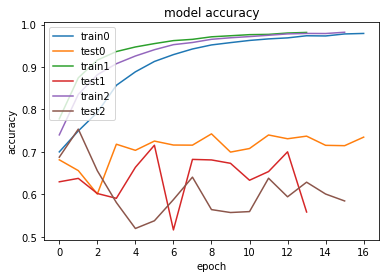

In [ ]:
for i in range(len(global_hist_acc)):
  plt.plot(global_hist_acc[i])
  plt.plot(global_hist_val_acc[i])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train0', 'test0', 'train1', 'test1', 'train2', 'test2'], loc='upper left')
plt.show()

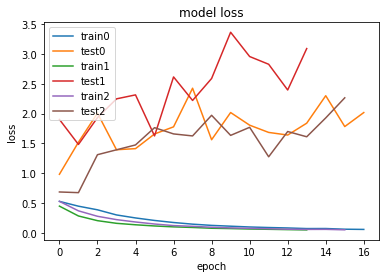

In [ ]:
for i in range(len(global_hist_loss)):
  plt.plot(global_hist_loss[i])
  plt.plot(global_hist_val_loss[i])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train0', 'test0', 'train1', 'test1', 'train2', 'test2'], loc='upper left')
plt.show()

### Validation metrics by images

In [ ]:
print("\n ========================== METRICS BY IMAGES ========================== ")
print(f'ACC: {np.mean(global_acc)}')
print(f'BACC: {np.mean(global_bacc)}')
print(f'F1: {np.mean(global_f1)}')
print(f'Recall: {np.mean(global_recall)}')
print(f'Precision: {np.mean(global_precision)}')
print(f'Specificity: {np.mean(global_specificity)}')
print(f'Sensitivity: {np.mean(global_sensitivity)}')
print(f'AUC: {np.mean(global_auc)}')
print(f'TP: {np.mean(global_tp)}')
print(f'TN: {np.mean(global_tn)}')
print(f'FP: {np.mean(global_fp)}')
print(f'FN: {np.mean(global_fn)}')


 ========================== METRICS BY IMAGES ========================== 
ACC: 0.7443768432258037
BACC: 0.6993808613146855
F1: 0.544593290610854
Recall: 0.6133480032710107
Precision: 0.4924319179638328
Specificity: 0.7854137193583602
Sensitivity: 0.6133480032710107
AUC: 0.797608226761601
TP: 131.0
TN: 463.0
FP: 129.0
FN: 75.33333333333333


Plot roc curves with auc for each validation folder

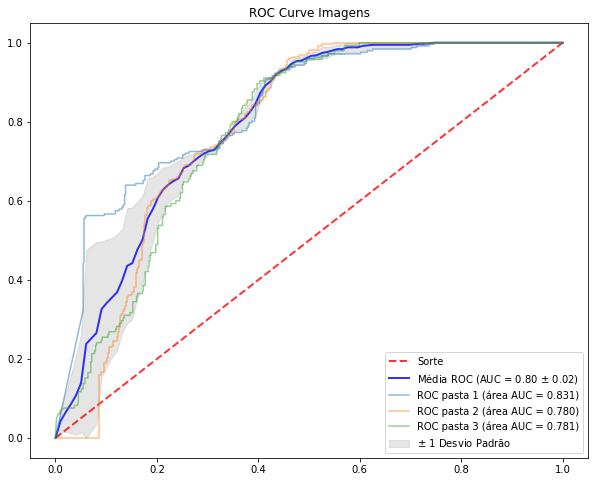

In [ ]:
mean_fpr = np.linspace(0, 1, 100)

tprs = []
aucs = []

for i, (fpr, tpr, _auc) in enumerate(roc_list):
  interp_tpr = np.interp(mean_fpr, fpr, tpr)
  interp_tpr[0] = 0.0
  tprs.append(interp_tpr)
  aucs.append(_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

fig, ax = plt.subplots(figsize=(10,8))

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Sorte", alpha=0.8)

ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Média ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

for i, (fpr, tpr, _auc) in enumerate(roc_list):
  ax.plot(fpr, tpr, label='ROC pasta {:} (área AUC = {:.3f})'.format(i+1, _auc), alpha=0.5)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 Std Deviation",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="ROC Curve Imagens",
)
ax.legend(loc="lower right")
plt.show()

### Validation metrics by patient

In [ ]:
print("\n ========================== METRICS BY PATIENT ========================== ")
print(f'ACC: {np.mean(global_acc_p)}')
print(f'BACC: {np.mean(global_bacc_p)}')
print(f'F1: {np.mean(global_f1_p)}')
print(f'Recall: {np.mean(global_recall_p)}')
print(f'Precision: {np.mean(global_precision_p)}')
print(f'Specificity: {np.mean(global_specificity_p)}')
print(f'Sensitivity: {np.mean(global_sensitivity_p)}')
print(f'AUC: {np.mean(global_auc_p)}')
print(f'TP: {np.mean(global_tp_p)}')
print(f'TN: {np.mean(global_tn_p)}')
print(f'FP: {np.mean(global_fp_p)}')
print(f'FN: {np.mean(global_fn_p)}')


 ========================== METRICS BY PATIENT ========================== 
ACC: 0.8024691358024691
BACC: 0.753968253968254
F1: 0.5952380952380952
Recall: 0.6666666666666666
Precision: 0.5416666666666666
Specificity: 0.8412698412698413
Sensitivity: 0.6666666666666666
AUC: 0.8253968253968255
TP: 4.0
TN: 17.666666666666668
FP: 3.3333333333333335
FN: 2.0


Plot roc curve with auc for each validation folder for patients

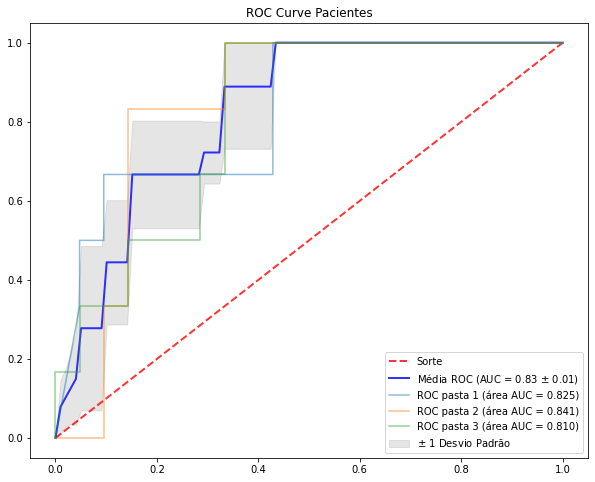

In [ ]:
mean_fpr_p = np.linspace(0, 1, 100)

tprs_p = []
aucs_p = []

for i, (fpr, tpr, _auc) in enumerate(roc_list_p):
  interp_tpr = np.interp(mean_fpr_p, fpr, tpr)
  interp_tpr[0] = 0.0
  tprs_p.append(interp_tpr)
  aucs_p.append(_auc)

mean_tpr_p = np.mean(tprs_p, axis=0)
mean_tpr_p[-1] = 1.0
mean_auc_p = metrics.auc(mean_fpr_p, mean_tpr_p)
std_auc_p = np.std(aucs_p)

fig, ax = plt.subplots(figsize=(10,8))

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Sorte", alpha=0.8)

ax.plot(
    mean_fpr_p,
    mean_tpr_p,
    color="b",
    label=r"ROC Mean (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc_p, std_auc_p),
    lw=2,
    alpha=0.8,
)

for i, (fpr, tpr, _auc) in enumerate(roc_list_p):
  ax.plot(fpr, tpr, label='ROC fold {:} (Area AUC = {:.3f})'.format(i+1, _auc), alpha=0.5)

std_tpr_p = np.std(tprs_p, axis=0)
tprs_upper_p = np.minimum(mean_tpr_p + std_tpr_p, 1)
tprs_lower_p = np.maximum(mean_tpr_p - std_tpr_p, 0)
ax.fill_between(
    mean_fpr_p,
    tprs_lower_p,
    tprs_upper_p,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 Std Deviation",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="ROC Curve Patients",
)
ax.legend(loc="lower right")
plt.show()

### Test metrics

In [ ]:
global_acc_p = []
global_bacc_p = []
global_f1_p = []
global_recall_p = []
global_precision_p = []
global_auc_p = []
global_sensitivity_p = []
global_specificity_p = []

global_tn_p = []
global_fp_p = []
global_fn_p = []
global_tp_p = []

global_specificity_p = []
global_sensitivity_p = []

roc_list = []
roc_list_p = []

Predict test results using test data and generate metrics

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


 *************************** AUC TEST PATIENTS 1 *************************** 



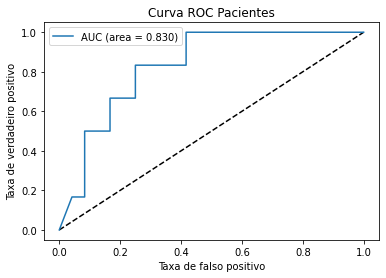


 *************************** CONFUSION MATRIX TEST PATIENTS 1 *************************** 

[[20  4]
 [ 2  4]]
0.8
0.75
0.5714285714285715
0.5
0.6666666666666666
0.4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


 *************************** AUC TEST PATIENTS 2 *************************** 



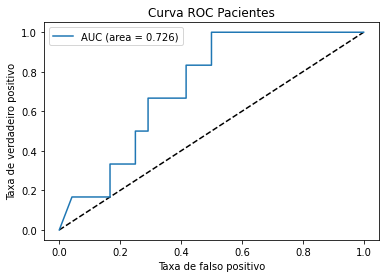


 *************************** CONFUSION MATRIX TEST PATIENTS 2 *************************** 

[[20  4]
 [ 5  1]]
0.7
0.5
0.1818181818181818
0.2
0.16666666666666666
0.1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


 *************************** AUC TEST PATIENTS 3 *************************** 



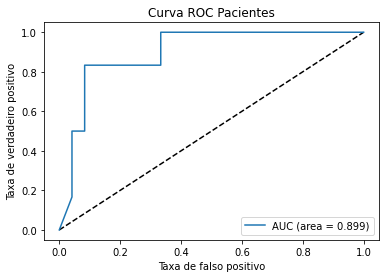


 *************************** CONFUSION MATRIX TEST PATIENTS 3 *************************** 

[[20  4]
 [ 1  5]]
0.8333333333333334
0.8333333333333334
0.6666666666666667
0.5555555555555556
0.8333333333333334
0.5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
for i in range(3):
  # Test path
  testDir = f'data/testDir'
  testdir_path = pathlib.Path(testDir)

  # Load model
  model = tf.keras.models.load_model(f'model_{i+1}.h5')

  # Download model
  fs.download(f'model_{i+1}.h5')

  # Compile model
  model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer = tf.keras.optimizers.Nadam(learning_rate=lr))

  # Get test files
  test_files = tf.data.Dataset.list_files(str(testdir_path/'*/*'), seed=_seed)

  # Labeled test data
  labeled_ds_test = test_files.map(read_files)

  # Generate predictions
  prediction = []
  _y = []
  files = []

  y_true_patients = {}
  y_pred_patients = {}
  y_probas_patients = {}

  # Divide test data in batches
  for p, z, y in labeled_ds_test.batch(batch_size):
    # predict data
    prediction.extend(model((p,get_tabular(z))).numpy().ravel())

    # Get ground truth label
    _y.extend(y.numpy())

    # Get file name
    files.extend(z)

  # Get predictions by patient
  for (y, _file, _pred, _prob) in zip(_y, files, (np.asarray(prediction) >= 0.5).astype("float"), prediction):
      _split = str(_file).split("/")
      _str = _split[len(_split) - 1].split("-")[0]

      if y_true_patients.get(_str) is None:
          y_true_patients[_str] = y

      if y_pred_patients.get(_str) is None:
          y_pred_patients[_str] = [_pred]
      else:
          y_pred_patients[_str].append(_pred)

      if y_probas_patients.get(_str) is None:
          y_probas_patients[_str] = [_prob]
      else:
          y_probas_patients[_str].append(_prob)

  # For each patient
  for p in y_probas_patients:
    # Probability is the median of images results
    y_probas_patients[p] = np.median(y_probas_patients[p])

    # Patient response is the mode of images results
    y_pred_patients[p] = stats.mode((np.array(y_pred_patients[p]) >= 0.5).astype("float"))[0][0]

  y_true_p = np.array(list(y_true_patients.values()))
  out_p = np.array(list(y_pred_patients.values()))
  probas_p = np.array(list(y_probas_patients.values()))

  # Generate test metrics
  print(f'\n *************************** AUC TEST PATIENTS {i+1} *************************** \n')
  # Test roc curve
  fpr_keras_p, tpr_keras_p, thresholds_keras_p = metrics.roc_curve(y_true_p, probas_p)

  # AUC
  __auc_p = metrics.roc_auc_score(y_true_p, probas_p)

  # Plot test roc curve with auc
  plt.figure(1)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr_keras_p, tpr_keras_p, label='AUC (area = {:.3f})'.format(__auc_p))
  plt.xlabel('False positive')
  plt.ylabel('True positive')
  plt.title('Curva ROC Patients')
  plt.legend(loc='best')
  plt.show()

  # Plot test data confusion matrix by patient
  print(f'\n *************************** CONFUSION MATRIX TEST PATIENTS {i+1} *************************** \n')

  print(metrics.confusion_matrix(y_true_p, out_p))
  tn_p, fp_p, fn_p, tp_p = metrics.confusion_matrix(y_true_p, out_p).ravel()

  global_tn_p.append(tn_p)
  global_fp_p.append(fp_p)
  global_fn_p.append(fn_p)
  global_tp_p.append(tp_p)

  try:
      global_specificity_p.append(tn_p / (tn_p+fp_p))
      global_sensitivity_p.append(tp_p / (tp_p+fn_p))
  except Exception as e:
      global_specificity_p.append(0)
      global_sensitivity_p.append(0)

  print(metrics.accuracy_score(y_true_p, out_p))
  print(metrics.balanced_accuracy_score(y_true_p, out_p))
  print(metrics.f1_score(y_true_p, out_p))
  print(metrics.precision_score(y_true_p, out_p))
  print(metrics.recall_score(y_true_p, out_p))
  print(metrics.jaccard_score(y_true_p, out_p))

  global_acc_p.append(metrics.accuracy_score(y_true_p, out_p))
  global_bacc_p.append(metrics.balanced_accuracy_score(y_true_p, out_p))
  global_f1_p.append(metrics.f1_score(y_true_p, out_p))
  global_precision_p.append(metrics.precision_score(y_true_p, out_p))
  global_recall_p.append(metrics.recall_score(y_true_p, out_p))
  global_auc_p.append(__auc_p)

  roc_list_p.append((fpr_keras_p, tpr_keras_p, __auc_p))

Mean test metrics


 ========================== METRICS BY PATIENT ========================== 
ACC: 0.7777777777777778
BACC: 0.6944444444444445
F1: 0.47330447330447334
Recall: 0.5555555555555555
Precision: 0.4185185185185185
Specificity: 0.8333333333333334
Sensitivity: 0.5555555555555555
AUC: 0.8182870370370369
TP: 3.3333333333333335
TN: 20.0
FP: 4.0
FN: 2.6666666666666665


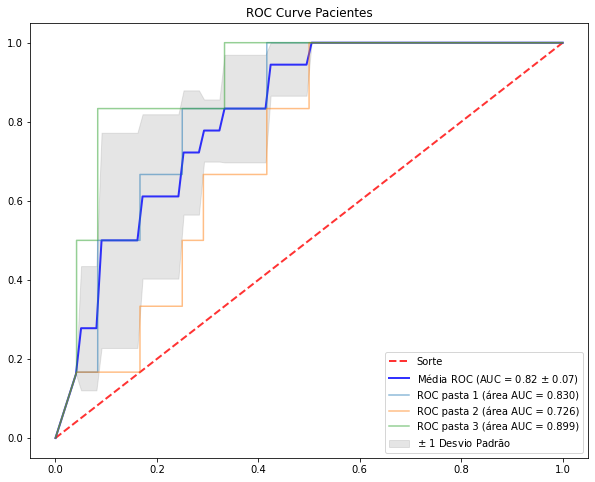

In [ ]:
print("\n ========================== METRICS BY PATIENT ========================== ")
print(f'ACC: {np.mean(global_acc_p)}')
print(f'BACC: {np.mean(global_bacc_p)}')
print(f'F1: {np.mean(global_f1_p)}')
print(f'Recall: {np.mean(global_recall_p)}')
print(f'Precision: {np.mean(global_precision_p)}')
print(f'Specificity: {np.mean(global_specificity_p)}')
print(f'Sensitivity: {np.mean(global_sensitivity_p)}')
print(f'AUC: {np.mean(global_auc_p)}')
print(f'TP: {np.mean(global_tp_p)}')
print(f'TN: {np.mean(global_tn_p)}')
print(f'FP: {np.mean(global_fp_p)}')
print(f'FN: {np.mean(global_fn_p)}')

mean_fpr_p = np.linspace(0, 1, 100)

tprs_p = []
aucs_p = []

for i, (fpr, tpr, _auc) in enumerate(roc_list_p):
  interp_tpr = np.interp(mean_fpr_p, fpr, tpr)
  interp_tpr[0] = 0.0
  tprs_p.append(interp_tpr)
  aucs_p.append(_auc)

mean_tpr_p = np.mean(tprs_p, axis=0)
mean_tpr_p[-1] = 1.0
mean_auc_p = metrics.auc(mean_fpr_p, mean_tpr_p)
std_auc_p = np.std(aucs_p)

fig, ax = plt.subplots(figsize=(10,8))

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Sorte", alpha=0.8)

ax.plot(
    mean_fpr_p,
    mean_tpr_p,
    color="b",
    label=r"Média ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc_p, std_auc_p),
    lw=2,
    alpha=0.8,
)

for i, (fpr, tpr, _auc) in enumerate(roc_list_p):
  ax.plot(fpr, tpr, label='ROC fold {:} (Area AUC = {:.3f})'.format(i+1, _auc), alpha=0.5)

std_tpr_p = np.std(tprs_p, axis=0)
tprs_upper_p = np.minimum(mean_tpr_p + std_tpr_p, 1)
tprs_lower_p = np.maximum(mean_tpr_p - std_tpr_p, 0)
ax.fill_between(
    mean_fpr_p,
    tprs_lower_p,
    tprs_upper_p,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 Std Deviation",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="ROC Curve Patients",
)
ax.legend(loc="lower right")
plt.show()